# Scene detection demo

In [1]:
import formatData
import utils
import subprocess
import gdown
import modelBuilder
import os
import torch
import numpy as np
import pims
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

/home/tristan/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 1. Getting key-frame indexes

In [2]:
videoPath = "../data/OVSD/Sintel.mp4" # Put the path to your file here
shotThres = 0.1                               # The shot detection threshold. Higher will produce less shot

videoName = os.path.basename(os.path.splitext(videoPath)[0])

if not os.path.exists("{}_shotBounds.csv".format(videoName)):
    nbFrames = formatData.getNbFrames(videoPath)
    fps = utils.getVideoFPS(videoPath)

    #Detecting shots boundaries. This can be a bit long
    shotBounds = formatData.detect_format_shots(videoPath,shotThres,nbFrames,fps)
       
    #Saving shot boundaries
    np.savetxt("{}_shotBounds.csv".format(videoName),shotBounds)
else:
    shotBounds = np.genfromtxt("{}_shotBounds.csv".format(videoName))
    
keyFrameInds = shotBounds.mean(axis=1).astype(int)

## 2. Loading the model

In [3]:

if not os.path.exists("./modelresnet50_biconvScoInitAtt_epoch462"):
    subprocess.call("gdown https://drive.google.com/uc?id=1WaAGxH4YzvNwvVP2Fjm4xtdgHIMRks1S",shell=True)
    
model = modelBuilder.SceneDet(temp_model="resnet50",featModelName="resnet50",cuda=torch.cuda.is_available(),\
                            scoreConvWindSize=7,scoreConvBiLay=True,scoreConvChan=8,scoreConvAtt=True)


params = torch.load("./modelresnet50_biconvScoInitAtt_epoch462",map_location=torch.device('cpu'))

state_dict = {k.replace("module.cnn.","cnn.module.")\
               .replace("scoreConv.weight","scoreConv.layers.weight")\
               .replace("scoreConv.bias","scoreConv.layers.bias")\
               .replace(".module","") : v for k,v in params.items()}

paramToRemove = []
for param in state_dict.keys():
    if param.find("frameAtt") != -1:
        paramToRemove.append(param)
for param in paramToRemove:
    state_dict.pop(param)

model.load_state_dict(state_dict)



IncompatibleKeys(missing_keys=[], unexpected_keys=[])

## 3. Computing the scene change scores

This computes the scene change score (or probability) given by the model to each shot of the movie. It plots the score for each shot of the video, along with the ground-truth scene change.

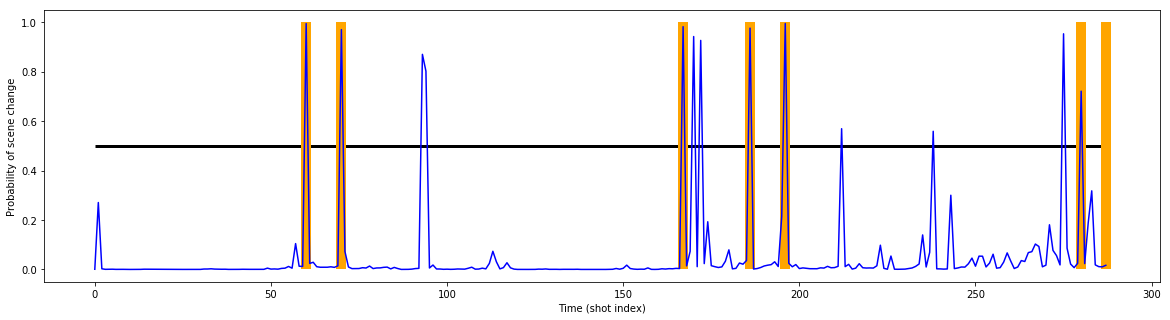

In [23]:
video = pims.Video(videoPath)

if not os.path.exists("res50_res50_biconvScoInitAtt_youtLarg_7_epoch462_{}.csv".format(videoName)):

    N = 10 #The model reads the first N shots at the same time, then the next N shots, etc.
    imgSize = 299


    #This separates the frame indexes into several batches which size is close to N
    split_keyFrameInds = np.array_split(keyFrameInds,len(keyFrameInds)//N+(len(keyFrameInds)%N != 0))

    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    preproc = transforms.Compose([transforms.ToPILImage(),transforms.CenterCrop(imgSize),transforms.ToTensor(),normalize])

    allScores = []

    for frameInds in split_keyFrameInds:

        frameSeq = torch.cat(list(map(lambda x:preproc(video[x]).unsqueeze(0),np.array(frameInds))),dim=0).unsqueeze(0)
        scores = model(frameSeq,None).data
        allScores.append(scores.squeeze(0))

    scores = torch.cat(allScores,dim=0)    
    scores = np.concatenate((keyFrameInds[np.newaxis],scores[np.newaxis,:]),axis=1)

    np.savetxt("res50_res50_biconvScoInitAtt_youtLarg_7_epoch462_{}.csv".format(videoName),scores)
else:
    scores = np.genfromtxt("res50_res50_biconvScoInitAtt_youtLarg_7_epoch462_{}.csv".format(videoName))
    
plt.figure(figsize=(20,5))

#Decision threshold
plt.hlines([0.5],0,len(scores),linewidths=3,color='black')

#Plot the scores
plt.plot(np.arange(len(scores)),scores[:,1],color="blue",label="Scene change score")

#Plot the GT
if not os.path.exists("Sintel_targ.csv"):
    subprocess.call("gdown https://drive.google.com/uc?id=129dQBUUzYjdlJYoy2nOX8yLSccS7Izam",shell=True)
gt = np.genfromtxt("Sintel_targ.csv")
plt.vlines(gt.nonzero(),0,1,linewidths=10,color='orange')

plt.xlabel("Time (shot index)")
plt.ylabel("Probability of scene change")
plt.show()

The black line is the decision threshold : above it the score is high enough and the shot is predicted as a scene change.
The orange line shows the ground truth scene changes
The blue line shows the score produced by the model.

We can see that there are almost all scene change are correctly captured and there only a few false positive.
Note that around shots 90-100, the model predicted two scene changes very confidently although there is no real scene change. By visualising the shots just below, we might suspect that this comes from the strong visual difference between shots 90-93 and shots 94-96

## 4. Showing the scene changes

This cell shows a few scene change predicted by the model. It shows a sequence of key-frames centered around a predicted scene change. The red line indicates between which shots the scene change is predicted to occur.

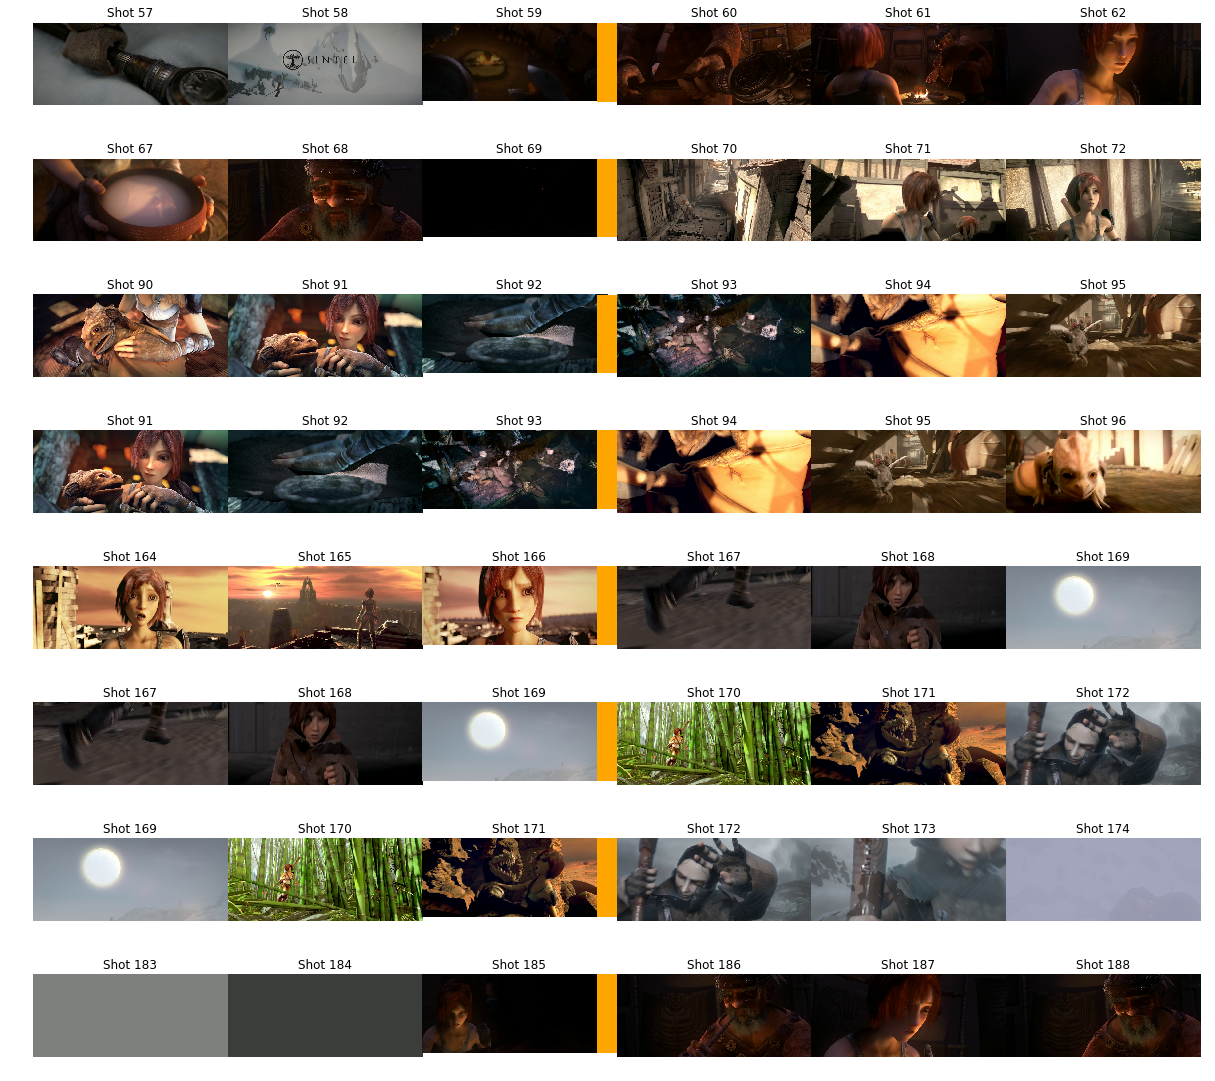

In [24]:
decisionThres = 0.5 # If a shot score is above this threshold, it will be considered as a scene change

#The index of the shots in which a scene change occurs
sceneChange_shotIndex = (scores[:,1]>decisionThres).nonzero()[0]
#The index of the frames in which a scene change occurs
sceneChange_frameIndex = shotBounds[sceneChange_shotIndex][:,0]

imgSize = 20
contextShots = 3
columns = 2*contextShots
rows = 8

frame = video[0]
ratio = frame.shape[1]/frame.shape[0] - 2

plt.figure(figsize=(imgSize*ratio*contextShots, imgSize))

gs1 = gridspec.GridSpec(rows, columns)
gs1.update(wspace=0.0, hspace=0.0)

#Each line shows one scene change (according to the model)
for i in range(rows):

    #Plot some key-frames before the scene change
    for j in range(contextShots):
        precKeyFrameInd = shotBounds[sceneChange_shotIndex[i]+j-contextShots].mean().astype(int)
        plt.subplot(gs1[i*columns+j])
        plt.title("Shot "+str(sceneChange_shotIndex[i]+j-contextShots))
        plt.axis('off')
        plt.imshow(video[precKeyFrameInd])
       
    plt.vlines([video[precKeyFrameInd].shape[1]],0,video[precKeyFrameInd].shape[0],color="orange",linewidths=20)
    
    #Plot some key-frames after the scene change
    for j in range(contextShots):
        keyFrameInd = shotBounds[sceneChange_shotIndex[i]+j].mean().astype(int)
        plt.subplot(gs1[i*columns+j+contextShots])
        plt.title("Shot "+str(sceneChange_shotIndex[i]+j))
        plt.axis('off')
        plt.imshow(video[keyFrameInd])

plt.show()
plt.savefig("{}_sceneChangeExamples.png")

Each line shows some key frames around the scene change predicted by the model.
Only the first 8 predicted scene change are shown.

The third and fourth scene change detected are false positives. We can suspect the model has predicted a change because of the strong visual difference between the shots 90-93 and the shots 94-96.